In [22]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Get the option prices from different strike and maturities

In [26]:
def get_strike_price_pivot_from_csv(csv_filename, maturity_min=None, maturity_max=None,
                                   moneyness_min=None, moneyness_max=None):

    df = pd.read_csv(csv_filename)

    if 'Maturity' not in df.columns or 'Strike' not in df.columns or 'Call' not in df.columns:
        raise ValueError("CSV missing required columns 'Maturity','Strike','Call'")

    # Filter by maturity if specified
    if maturity_min is not None:
        df = df[df['Maturity'] >= maturity_min]
    if maturity_max is not None:
        df = df[df['Maturity'] <= maturity_max]

    # Filter by moneyness if specified and spot price provided
    if spot is not None:
        if moneyness_min is not None:
            df = df[df['Strike'] >= moneyness_min * spot]
        if moneyness_max is not None:
            df = df[df['Strike'] <= moneyness_max * spot]
    elif moneyness_min is not None or moneyness_max is not None:
        raise ValueError("Spot price must be provided for moneyness filtering")

    # Find strikes common to all maturities in filtered data
    num_maturities = df['Maturity'].nunique()
    strike_counts = df['Strike'].value_counts()
    common_strikes = strike_counts[strike_counts == num_maturities].index
    df = df[df['Strike'].isin(common_strikes)]

    table = df.pivot(index='Maturity', columns='Strike', values='Call').fillna(0)

    return table

csv_file = "option_data/AAPL_option_data_spot_255_date_28_sep_2025.csv"
spot = 255  
# csv_file = "option_data/MSFT_option_data_spot_511_date_28_sep_2025.csv"
# spot = 511  

table = get_strike_price_pivot_from_csv(csv_file, maturity_min=0.2, maturity_max=0.8,
                                                moneyness_min=0.8, moneyness_max=1.6)


In [27]:
table

Strike,210.0,220.0,230.0,240.0,250.0,260.0,270.0,280.0,290.0,300.0,310.0,320.0,330.0,340.0,350.0
Maturity,,,,,,,,,,,,,,,
0.2103,47.225,37.975,29.075,20.875,13.875,8.450,4.700,2.430,1.205,0.600,0.300,0.150,0.080,0.045,0.030
0.3214,48.700,39.650,31.050,23.200,16.375,10.900,6.775,3.950,2.180,1.195,0.645,0.350,0.190,0.110,0.065
0.4325,50.125,41.250,32.925,25.300,18.600,13.025,8.675,5.500,3.350,1.985,1.155,0.680,0.390,0.235,0.145
0.5714,52.000,43.375,35.400,28.125,21.550,15.975,11.425,7.925,5.275,3.475,2.260,1.460,0.950,0.625,0.410
0.6825,53.325,45.025,37.175,30.025,23.550,17.975,13.300,9.550,6.725,4.650,3.175,2.175,1.475,1.010,0.700
0.7937,54.575,46.375,38.725,31.625,25.225,19.650,14.875,11.100,8.025,5.725,4.000,2.830,1.995,1.420,0.995


### Plot the call prices vs strike for different maturities

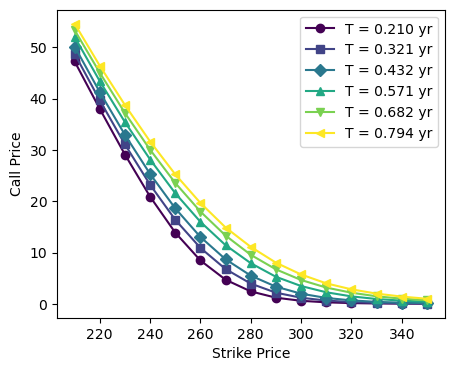

In [28]:


def plot_call_price_strikes(data, figsize=(5, 4), cmap_name='viridis', ncols_legend=1):
    
    strikes = data.columns.values

    cmap = plt.colormaps[cmap_name].resampled(len(data.index))

    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'H', 
               'h', '*', '+', 'x', 'X', 'd', '|', '_', '.']
    
    plt.figure(figsize=figsize)
    
    for idx, maturity in enumerate(data.index):
        call_prices = data.loc[maturity].values
        marker_style = markers[idx % len(markers)]
        plt.plot(strikes, call_prices, marker=marker_style,
                 color=cmap(idx), label=f'T = {maturity:.3f} yr')
    
    plt.xlabel("Strike Price")
    plt.ylabel("Call Price")
    plt.legend(ncol=ncols_legend)
    plt.show()

plot_call_price_strikes(table)


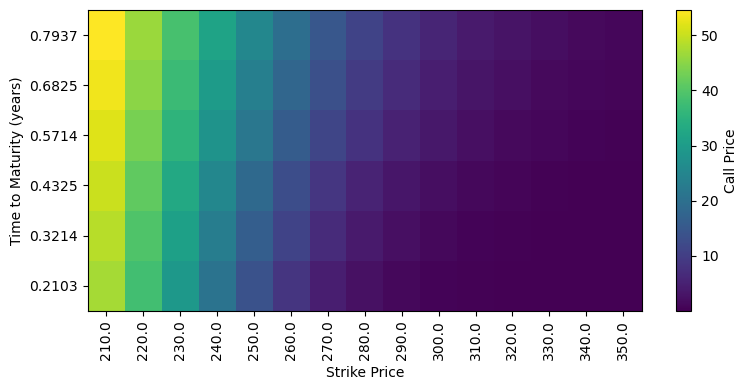

In [29]:
def plot_call_price_heatmap(data, figsize=(8,4), cmap_name='viridis'):
    
    plt.figure(figsize=figsize)
    
    img = plt.imshow(data.values, aspect='auto', origin='lower', 
                     interpolation='none', cmap=plt.colormaps[cmap_name])
    
    plt.colorbar(img, label='Call Price')
    
    # Label ticks with strike and maturity values
    plt.xticks(ticks=np.arange(data.shape[1]), labels=list(data.columns), rotation=90)
    plt.yticks(ticks=np.arange(data.shape[0]), labels=list(data.index))
    
    plt.xlabel('Strike Price')
    plt.ylabel('Time to Maturity (years)')
    plt.tight_layout()
    plt.show()

plot_call_price_heatmap(table)


### Nelson-Siegel-Svensson model to risk-free yield curve to market data

In [31]:
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

def get_data(spot, data, yields, maturities):
    strikes = data.columns.values
    maturity = data.index.values
    option_prices = data.values

    # Copy data to avoid changing original DataFrame
    data_copy = data.copy()

    curve_fit, _ = calibrate_nss_ols(maturities, yields)

    # Map rates using the curve on the index and store in copy
    data_copy["rate"] = data_copy.index.map(curve_fit) * 0.01
    rates = data_copy["rate"].values

    return {
        "spot": spot,
        "strikes": strikes,
        "maturities": maturity,
        "option_prices": option_prices,
        "rates": rates,
    }

## https://www.slickcharts.com/treasury
## 1 m, 1.5m, 2m,...1yr, 2yr, 10yr yields as of 28 Sep 2025
yields = np.array([4.22, 4.20, 4.17, 4.02, 4.00, 3.83, 3.67, 3.63, 3.66, 3.76, 3.96, 4.20, 4.74, 4.77])
yields_maturity = np.array([1/12, 1.5/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])

data = get_data(spot, table, yields, yields_maturity)


In [32]:
print("Spot Price :", data['spot'])
print("Strikes :", data['strikes'])
print("Maturity :", data['maturities'])
print(len(data['strikes']), len(data['maturities']))

Spot Price : 255
Strikes : [210. 220. 230. 240. 250. 260. 270. 280. 290. 300. 310. 320. 330. 340.
 350.]
Maturity : [0.2103 0.3214 0.4325 0.5714 0.6825 0.7937]
15 6


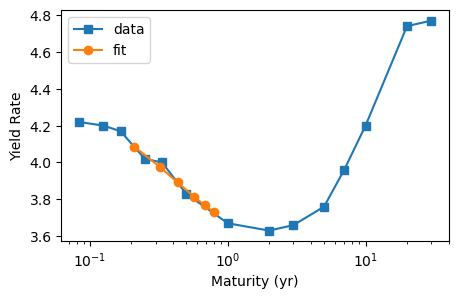

In [33]:
plt.figure(figsize=(5,3))
plt.plot(yields_maturity, yields, 's-', label='data')
plt.plot(data['maturities'], data['rates']/0.01, 'o-', label='fit')
plt.xscale('log')

plt.xlabel("Maturity (yr)")
plt.ylabel("Yield Rate")
plt.legend()

### Heston Price Calibration 

In [12]:
from heston.P1P2Heston import heston_call_price
from scipy.optimize import minimize

def calibrate_heston(data):
    
    spot, strikes, maturities, option_prices, rates = (
        data["spot"], data["strikes"], data["maturities"], 
        data["option_prices"], data["rates"])

    params = {
        "v0": (0.1, (1e-2, 1)),
        "kappa": (3, (1e-2, 5)),
        "theta": (0.05, (1e-2, 1)),
        "sigma": (0.3, (1e-2, 2)),
        "rho": (-0.8, (-1, 1)),
    }
    x0 = np.array([v for v, _ in params.values()])
    bounds = [b for _, b in params.values()]

    history = []
    losses = []

    def callback_fun(x):
        history.append(x.copy())
        losses.append(objective(x))

    def feller_condition(x):
        _, kappa, theta, sigma, _ = x
        return 2 * kappa * theta - sigma**2

    def objective(x):
        v0, kappa, theta, sigma, rho = x
        model_prices = np.array([
            [heston_call_price(spot, K, rates[i], tau, kappa, theta, sigma, rho, v0)
             for K in strikes]
            for i, tau in enumerate(maturities)
        ])
        mse = np.mean((model_prices - option_prices) ** 2)
        feller_penalty = max(0, sigma**2 - 2 * kappa * theta)
        return mse + 1e4 * feller_penalty

    result = minimize(
        objective, x0, method="SLSQP",
        bounds=bounds, constraints=[{"type": "ineq", "fun": feller_condition}],
        options={"ftol": 1e-5, "maxiter": 2000},
        callback=callback_fun,
    )

    return result, np.array(history), np.array(losses)


In [13]:
result, history, losses = calibrate_heston(data)


/Users/tanmoy/miniconda3/envs/fin_env/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


### plot parameter and loss convergence with iteration

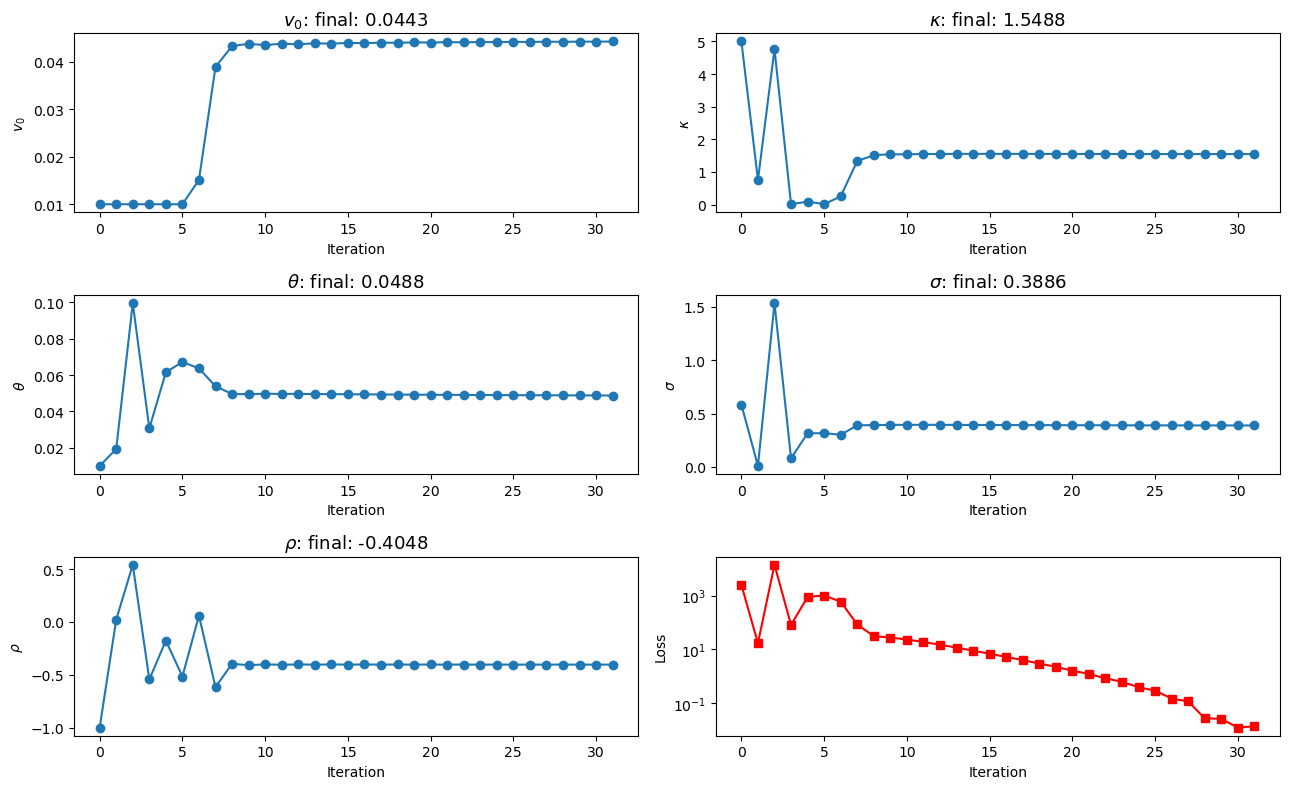

In [14]:

def plot_convergence(history, losses):
    
    param_latex = [r"$v_0$", r"$\kappa$", r"$\theta$", r"$\sigma$", r"$\rho$"]
    num_params = len(param_latex)
    fig, axs = plt.subplots(3, 2, figsize=(13, 8))
    for i, latex_name in enumerate(param_latex):
        ax = axs.flatten()[i]
        vals = history[:, i]
        lastval = vals[-1]
        ax.plot(vals, marker="o", linewidth=1.5)
        ax.set_title(f"{latex_name}: final: {lastval:.4f}", fontsize=13)
        ax.set_xlabel("Iteration")
        ax.set_ylabel(latex_name)

    ax = axs.flatten()[num_params]
    ax.plot(losses, marker="s", color="red", linewidth=1.5)
    ax.set_yscale("log") 
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    plt.tight_layout()
    plt.show()

plot_convergence(history, losses)

In [15]:
def check_feller(params, verbose=True):
    """
    Check the Feller condition for the Heston variance process:
        2 * kappa * theta > sigma**2
    """
    _, kappa, theta, sigma, _ = params

    fel_cond = 2*kappa*theta/(sigma**2)

    print("2 * kappa * theta by sigma**2 :", fel_cond)

    if verbose:
        if fel_cond>=1:
            print("Feller condition HOLDS")
        else:
            print("Feller condition VIOLATED")

    # return fel_cond

check_feller(result.x, verbose=True)
print("Optimised paramters: ",result.x)

2 * kappa * theta by sigma**2 : 1.000022414972959
Feller condition HOLDS
Optimised paramters:  [ 0.04426998  1.54740522  0.0488007   0.38862003 -0.40395775]


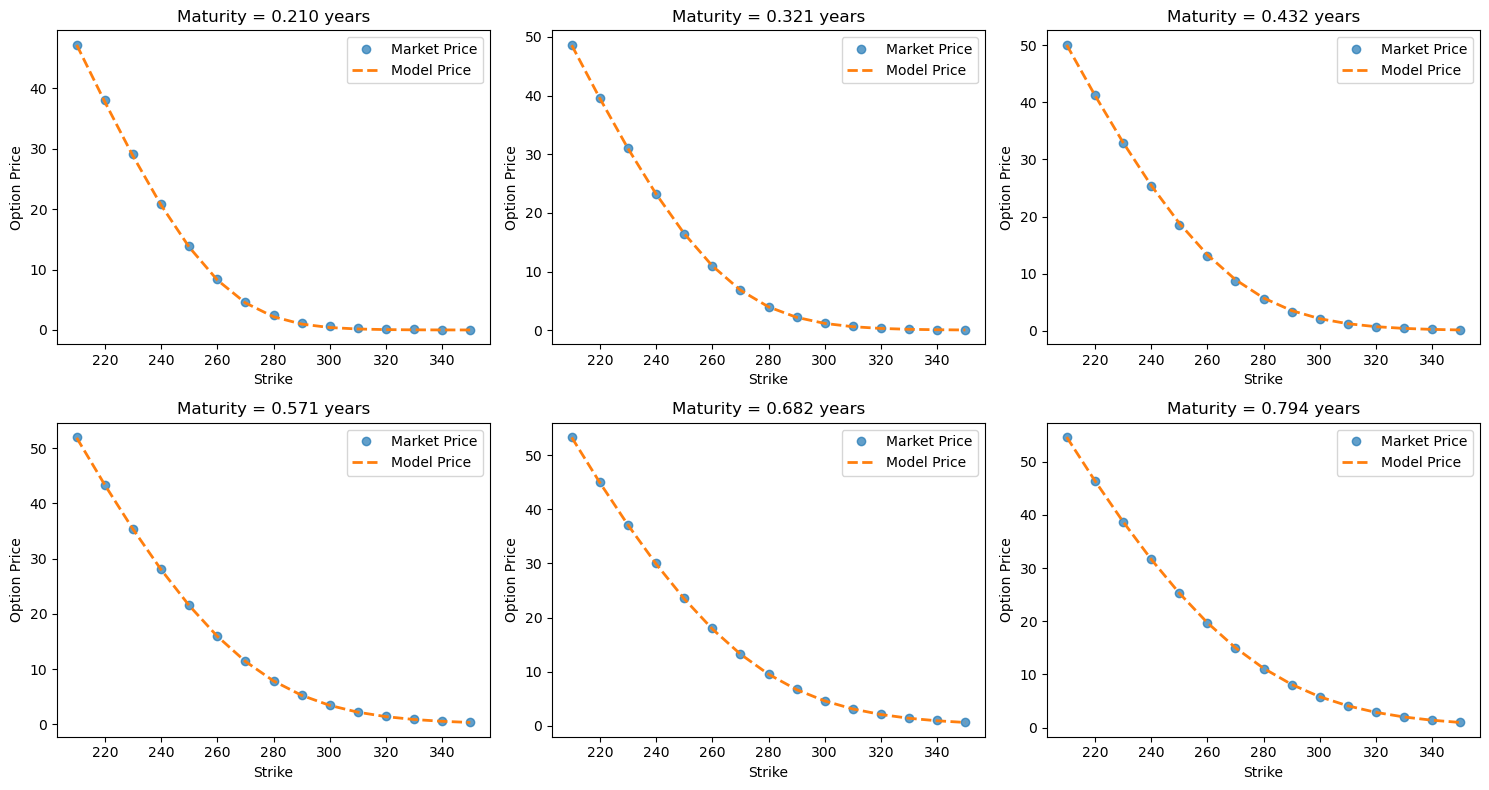

In [ ]:
def plot_market_vs_model_prices(data, result, heston_call_price):

    spot = data["spot"]
    strikes = data["strikes"]
    maturities = data["maturities"]
    market_prices = data["option_prices"]
    rates = data["rates"]

    v0, kappa, theta, sigma, rho = result.x

    n_maturities = len(maturities)
    ncols = 3
    nrows = (n_maturities + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharex=False, sharey=False)
    axs = axs.flatten()

    for i, tau in enumerate(maturities):
        model_prices = np.array([
            heston_call_price(spot, K, rates[i], tau, kappa, theta, sigma, rho, v0)
            for K in strikes
        ])
        ax = axs[i]
        ax.plot(strikes, market_prices[i], 'o', label='Market Price', alpha=0.7)
        ax.plot(strikes, model_prices, '--', label='Model Price', linewidth=2)
        ax.set_title(f'Maturity = {tau:.3f} years')
        ax.set_xlabel('Strike')
        ax.set_ylabel('Option Price')
        ax.legend()

    # Clean up any empty subplots if maturities % ncols != 0
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    # plt.savefig("Model_vs_Market_Price.png", dpi=900, bbox_inches="tight")
    plt.show()


plot_market_vs_model_prices(data, result, heston_call_price)


In [19]:

import plotly.graph_objects as go

def plot_market_vs_model_surface(data, result, heston_call_price):

    spot = data["spot"]
    strikes = data["strikes"]
    maturities = data["maturities"]
    market_prices = data["option_prices"]
    rates = data["rates"]

    v0, kappa, theta, sigma, rho = result.x

    Strikes, Maturities = np.meshgrid(strikes, maturities)

    Market_surface = np.array(market_prices)

    Model_surface = np.array([
        [heston_call_price(spot, K, r, tau, kappa, theta, sigma, rho, v0)
         for K in strikes]
        for tau, r in zip(maturities, rates)])

    fig = go.Figure()

    fig.add_trace(go.Surface(
        x=Strikes, y=Maturities, z=Market_surface,
        colorscale="Greens", opacity=0.5,
        name="Market Price",
        showscale=True,
        colorbar=dict(title="Market Price", x=-0.1)
    ))
     
    fig.add_trace(go.Scatter3d(
        x=Strikes.flatten(),
        y=Maturities.flatten(),
        z=Market_surface.flatten(),
        mode='markers',
        marker=dict(color='black', size=4, opacity=0.8),
        name='Market Price Points'
    ))

    fig.add_trace(go.Surface(
        x=Strikes, y=Maturities, z=Model_surface,
        colorscale="Reds", opacity=0.8,
        name="Model Price",
        showscale=True,
        colorbar=dict(title="Model Price", x=1.05)
    ))

    fig.update_layout(
        title="Market vs Heston Model Option Price Surfaces",
        scene=dict(
            xaxis_title="Strike",
            yaxis_title="Maturity (years)",
            zaxis_title="Option Price"
        ),
        width=900,
        height=600,
    )

    fig.show()

plot_market_vs_model_surface(data, result, heston_call_price)